In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import sys
import csv
import functools
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import string
from vigipy import *
import unittest
from vigipy import bcpnn, gps, ror, rfet, prr, convert, LongitudinalModel

In [2]:
dfRaw = pd.read_pickle("./dfResultsRFo")

In [3]:
# creating df to input into the DPA model
df = pd.DataFrame(columns=["AE"])
df["AE"] = dfRaw["PREDICTED"]

countList = []
n=0
while n < 15947:
    countList.append(1)
    n += 1

df["count"] = countList
df["name"] = dfRaw["STD_DEVICE"]
df["date"] = pd.to_datetime(dfRaw["DATE_RECEIVED"].astype(str))

In [4]:
df.head()

,AE,count,name,date
0,1,1,MEDTRONIC_VISIA,2018-07-02
1,1,1,StJUDE_ELLIPSE,2013-09-10
2,1,1,MEDTRONIC_SPRINT_QUATTRO,2013-02-11
3,0,1,StJUDE_ELLIPSE,2013-09-10
4,0,1,MEDTRONIC_SPRINT_QUATTRO,2013-02-11


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15947 entries, 0 to 15946
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   AE      15947 non-null  object        
 1   count   15947 non-null  int64         
 2   name    15947 non-null  object        
 3   date    15947 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 622.9+ KB


<ipython-input-6-fb6b3645555f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Quarter'] = df_1['date'].dt.to_period('Q')


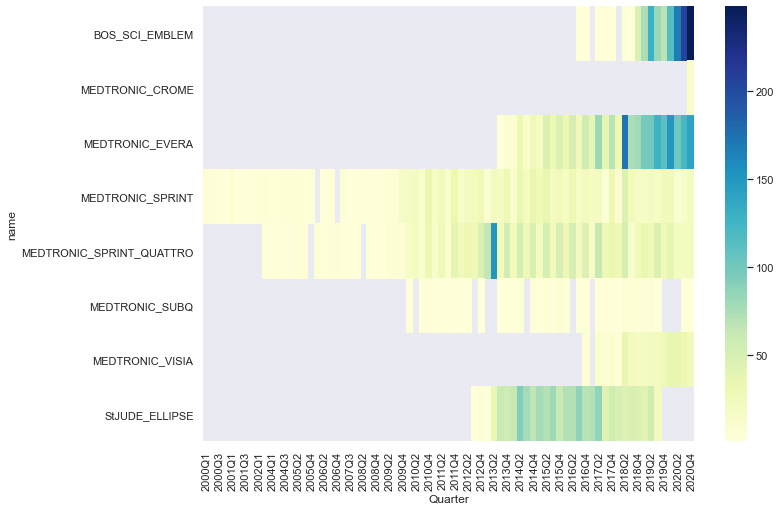

In [6]:
# plotting predicted adverse MDR counts
df_1 = df.loc[df['AE']=="1"]
df_1['Quarter'] = df_1['date'].dt.to_period('Q')
dfPT = df_1.pivot_table(values='count', index = 'name', columns= 'Quarter', aggfunc= np.sum)

sns.set(rc={'figure.figsize':(11,8)})
ax = sns.heatmap(dfPT,cmap="YlGnBu")

In [7]:
LM = LongitudinalModel(df, 'Q')
LM.run_disjoint(gps, False, min_events=0)

/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))
/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))
/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))
/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))
/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))
/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))
/Users/inba/opt/anaconda3/lib/python3.8/vigipy/GPS/GPS.py:286: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(term))

In [21]:
LM.results[77][1].signals

,Product,Adverse Event,Count,Expected Count,log2,count/expected,product margin,event margin,fdr,FNR,Se,Sp,LowerBound,p_value
0,MEDTRONIC_SPRINT,0,24.0,4.391555,2.31759479665169,5.465035,44.0,52.0,0.499914,0.563709,0.181535,0.897301,3.305187,1.594929e-09
1,MEDTRONIC_SPRINT_QUATTRO,0,22.0,4.491363,2.10485664532973,4.898291,45.0,52.0,0.333276,0.585786,0.363039,0.785672,2.812708,5.588067e-08
2,BOS_SCI_EMBLEM,1,248.0,223.247601,0.145316905027639,1.110874,248.0,469.0,0.334875,0.780823,0.603615,0.421650,0.995343,5.778130e-02


In [23]:
L1 = []
L2 = []
L3 = []

DPAdf = pd.DataFrame(columns=['Date','Product','p_value'])

for timestamp, result in LM.results:
    for n in result.signals.index:
        if result.signals.loc[n,'Adverse Event'] == "1":
            L1.append(timestamp)
            L2.append(result.signals.loc[n,'Product'])
            L3.append(result.signals.loc[n,'p_value'])    

In [24]:
DPAdf['Date'] = L1
DPAdf['Product'] = L2
DPAdf['Quantile'] = L3

DPAdf['Quarter'] = pd.to_datetime(DPAdf['Date']).dt.to_period('Q')
DPAdf.head()

,Date,Product,p_value,Quantile,Quarter
0,2005-09-30,MEDTRONIC_SPRINT_QUATTRO,NaN,0.407104,2005Q3
1,2009-09-30,MEDTRONIC_SPRINT_QUATTRO,NaN,0.267605,2009Q3
2,2009-12-31,MEDTRONIC_SPRINT,NaN,0.327313,2009Q4
3,2010-06-30,MEDTRONIC_SPRINT,NaN,0.126344,2010Q2
4,2012-03-31,MEDTRONIC_SPRINT_QUATTRO,NaN,0.288157,2012Q1


In [25]:
DPAPT = DPAdf.pivot('Product', 'Quarter', 'Quantile')
DPAPT.head()

Quarter,2005Q3,2009Q3,2009Q4,2010Q2,2012Q1,2012Q4,2013Q2,2013Q3,2013Q4,2014Q1,...,2018Q2,2018Q3,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4
Product,,,,,,,,,,,,,,,,,,,,,
BOS_SCI_EMBLEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.035911,0.041108,0.045167,0.02432,0.057781
MEDTRONIC_EVERA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.181256,NaN,0.332769,NaN,0.104199,0.032308,0.079812,0.178608,0.10927,NaN
MEDTRONIC_SPRINT,NaN,NaN,0.327313,0.126344,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEDTRONIC_SPRINT_QUATTRO,0.407104,0.267605,NaN,NaN,0.288157,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEDTRONIC_SUBQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


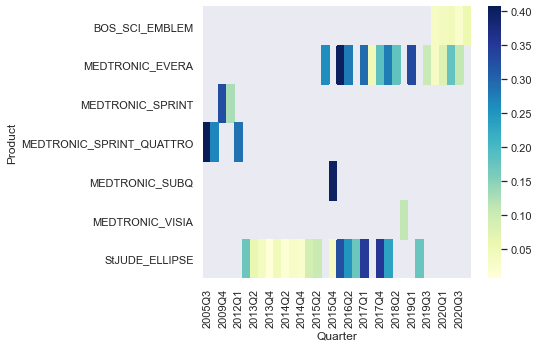

In [26]:
sns.set(rc={'figure.figsize':(6,5)})
ax = sns.heatmap(DPAPT,cmap="YlGnBu")

In [27]:
'''
Recall Dates:

[02/03/21] 
> Evera

[02/03/21]
> Visia

[02/05/21]
> Emblem

[08/02/2019]
> Ellipse
'''

'\n[02/03/21] \n> Evera\n\n[02/03/21]\n> Visia\n\n[02/05/21]\n> Emblem\n\n[08/02/2019]\n> Ellipse\n'